<a href="https://colab.research.google.com/github/Sunny18-2002/IIITH-project/blob/main/YOLOv8x_weed_crop_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'weedcrop-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2307840%2F3883792%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240214%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240214T041829Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D47e7dcd009bf1733fe4f6b0a77c6c312f1b74e32d34c40065fa3d85c2d2c1fa017811f97bc4dad588edc248ba647334688b06b4ea244a100f04c94c6754f97039fecf5315a04fa239b5cc513ffcf4b6fad0e3f0f79eb67094cbbce741bb5f8784749c310574128d73c1b2e0473b104d4150d733676cbab674fb3114b9e5183b292a4ba2eb95885bf6bfdfc149ccbc950397b20581c9c0d45536b18f940e69ea3ab82459b001d64782197c8e20d8a5d160f4bf711f8b29ec794252ca4bf05922f6e98365a8af6c64bae754bd05493e81fe222dc34cab27baee1b27a12975b4f241d5c41390fba097677195d9278371387a7d2e773acafc14287c1b0a3433f1605,amiran:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3436199%2F5997654%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240214%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240214T041830Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D169e3102e60a796611d340640885e9d9ab8cda52e346ea9754eb7f4381b94df50af2a139c4cb1225b6819f09cbee0736f1cc6262c7b4faf0497fbad781fee22f502d7e644af35ee85c4f9d7d49933901f066a13c0d2c0df201ee19d595e8a6f56239f140f23fbd91c31cd29e52a2074ba9769921594691d282f74b8ae5a74b79542368e59f9c70eec6329d7e970af9ed198ede4a733065c148c56c4d931a7ed8bc5c0ba416cdf03b2ce7220c54e9a93b8b5b284e000a36212bcff50066e49cb2907a8a174ce938504eab92eaa974bd5c568da52d6d690bbc8cb5aed5563f7ede098b73b34d91d5ab924fe075221b65dabd2901ec60cdb6257c6e9d1c6a0df4f4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.2/710.2 kB 11.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


**In this notebook, I will demonstrate how to solve the weed detection task for the agricultural sector using the state-of-the-art YOLOv8x model.**

In [ ]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import torch

import shutil
import os

import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data preparation

**For training data, I utilized two datasets: the WeedCrop Image Dataset comprising 2822 images of various qualities and LincoInBeet comprising 4402 high-quality images sized at 1920 x 1080 pixels.**

**In total, we have 7224 images. We will split them in a ratio of 5558:676:990 for train:val:test, respectively.**

**But first, we need to gather and structure the datasets.**

In [ ]:
source_folder = "/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch"

# Folder test
test_source_images = os.path.join(source_folder, "test/images")
test_source_labels = os.path.join(source_folder, "test/labels")

test_destination_folder = "/kaggle/working/test"
os.makedirs(test_destination_folder, exist_ok=True)

# Image movement
shutil.copytree(test_source_images, os.path.join(test_destination_folder, "images"))

# label movement
shutil.copytree(test_source_labels, os.path.join(test_destination_folder, "labels"))


# folder train
train_source_images = os.path.join(source_folder, "train/images")
train_source_labels = os.path.join(source_folder, "train/labels")

train_destination_folder = "/kaggle/working/train"
os.makedirs(train_destination_folder, exist_ok=True)

# moving images
shutil.copytree(train_source_images, os.path.join(train_destination_folder, "images"))

# Moving labels
shutil.copytree(train_source_labels, os.path.join(train_destination_folder, "labels"))


# Folder valid
valid_source_images = os.path.join(source_folder, "valid/images")
valid_source_labels = os.path.join(source_folder, "valid/labels")

valid_destination_folder = "/kaggle/working/valid"
os.makedirs(valid_destination_folder, exist_ok=True)

# Moving images
shutil.copytree(valid_source_images, os.path.join(valid_destination_folder, "images"))

# Moving labels
shutil.copytree(valid_source_labels, os.path.join(valid_destination_folder, "labels"))

'/kaggle/working/valid/labels'

In [ ]:
def move_files(file_path, source_folder, destination_folder):
    # Reading the list of file names
    with open(file_path, "r") as file:
        file_names = [os.path.basename(line.strip()) for line in file.readlines()]

    # Folders for images and labels
    images_folder = os.path.join(destination_folder, "images")
    labels_folder = os.path.join(destination_folder, "labels")

    # Moving files
    for file_name in file_names:
        image_file = os.path.join(source_folder, file_name)
        label_file = os.path.join(source_folder, file_name.replace(".png", ".txt"))
        if os.path.isfile(image_file):
            shutil.copy(image_file, images_folder)
        if os.path.isfile(label_file):
            shutil.copy(label_file, labels_folder)

In [ ]:
train_file = "/kaggle/input/amiran/all_fields_lincolnbeet/all_fields_lincolnbeet_train_.txt"
valid_file = "/kaggle/input/amiran/all_fields_lincolnbeet/all_fields_lincolnbeet_val_.txt"
test_file = "/kaggle/input/amiran/all_fields_lincolnbeet/all_fields_lincolnbeet_test_.txt"

source_folder = "/kaggle/input/amiran/all_fields_lincolnbeet/all"
train_destination = "/kaggle/working/train"
valid_destination = "/kaggle/working/valid"
test_destination = "/kaggle/working/test"

move_files(train_file, source_folder, train_destination)
move_files(valid_file, source_folder, valid_destination)
move_files(test_file, source_folder, test_destination)

In [ ]:
# Let's create a YAML file for YOLO
import  yaml

# Data structure
dataset = {
'train': '/kaggle/working/train',
'val': '/kaggle/working/valid',
'test': '/kaggle/working/test',
'nc': 2,
'names': ['crop', 'weed']
}

# save to YAML-file
with open('/kaggle/working/dataset.yaml', 'w') as file:
    yaml.dump(dataset, file)

In [ ]:
ls /kaggle/working

dataset.yaml  test/  train/  valid/


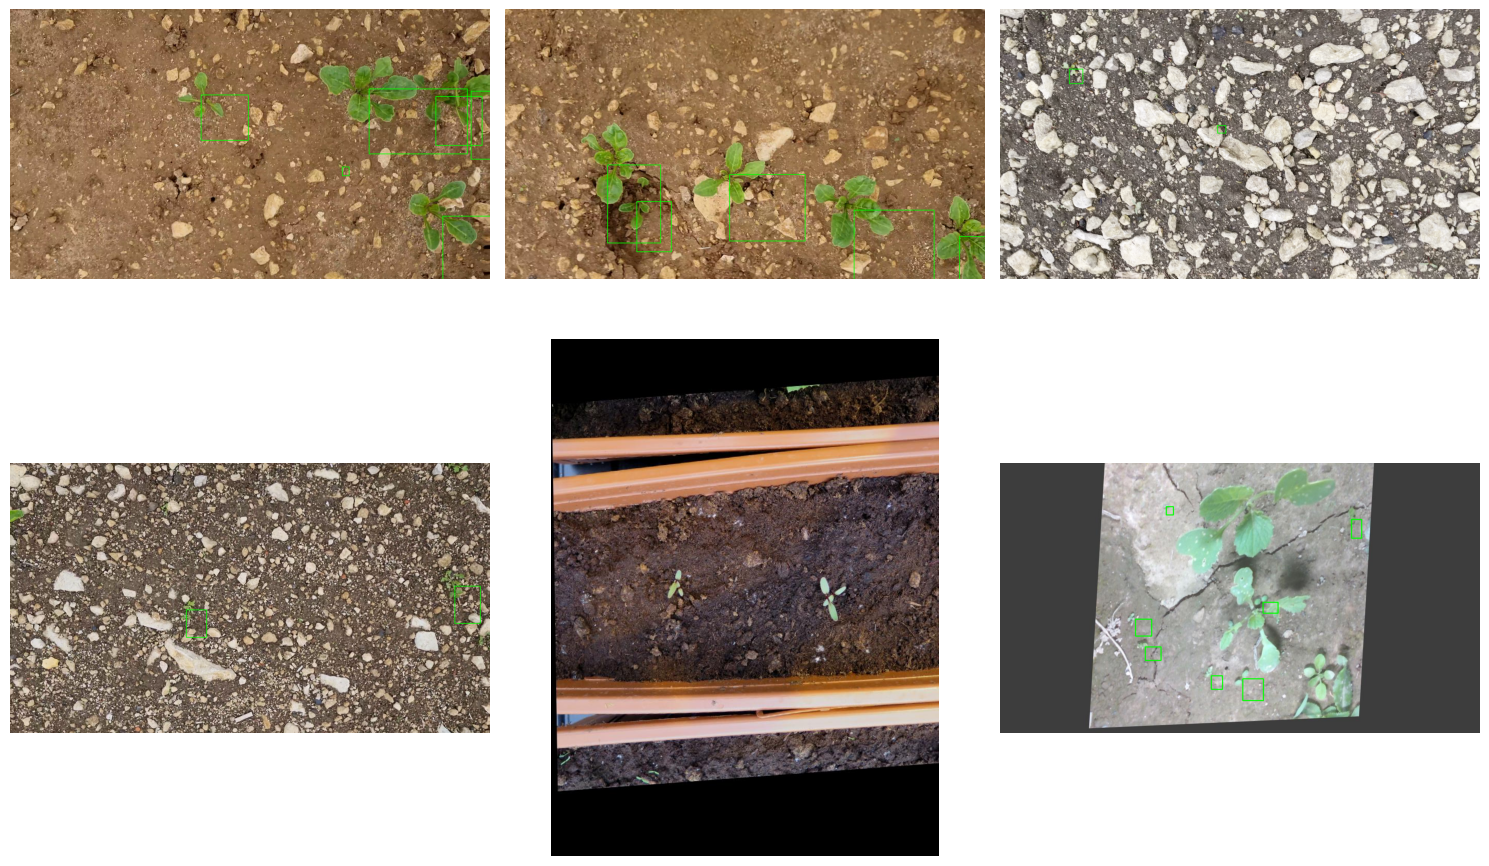

In [ ]:
# Folders with images and labels
images_folder = "/kaggle/working/train/images"
labels_folder = "/kaggle/working/train/labels"

# Loading the list of image files
image_files = os.listdir(images_folder)

# Selecting random images
random.shuffle(image_files)
random_image_files = image_files[:6]

# Displaying random images with labels
num_images = len(random_image_files)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_images):
    # Image loading
    image_file = os.path.join(images_folder, random_image_files[i])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Loading labels from file
    label_file = os.path.join(labels_folder, os.path.splitext(random_image_files[i])[0] + ".txt")
    with open(label_file, "r") as file:
        labels = file.readlines()

    # Displaying image with labels
    for label in labels:
        class_id, x, y, width, height = map(float, label.strip().split())
        x = int(x * image.shape[1])
        y = int(y * image.shape[0])
        width = int(width * image.shape[1])
        height = int(height * image.shape[0])
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Image display
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Train loop

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 259MB/s]  


In [ ]:
model.train(data='/kaggle/working/dataset.yaml ', epochs=50, imgsz=640,
            optimizer = 'AdamW', lr0 = 1e-3,
            project = 'TG_YOLOv8x', name='Didi',
            batch=16, device=device, seed=69)

Ultralytics YOLOv8.1.12 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/dataset.yaml , epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=TG_YOLOv8x, name=Didi, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=69, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 74.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 5550 images, 109 backgrounds, 0 corrupt: 100%|██████████| 5558/5558 [00:40<00:00, 136.06it/s]

train: WARNING ⚠️ /kaggle/working/train/images/near30_near30_01_06_2021_v_0_63.png: 1 duplicate labels removed


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/valid/labels... 675 images, 1 backgrounds, 0 corrupt: 100%|██████████| 676/676 [00:06<00:00, 105.42it/s]


val: New cache created: /kaggle/working/valid/labels.cache
Plotting labels to TG_YOLOv8x/Didi/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to TG_YOLOv8x/Didi
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      16.1G      1.412      1.231      1.148         54        640: 100%|██████████| 348/348 [08:47<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:15<00:00,  1.41it/s]


                   all        676       5456      0.578      0.623      0.609      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      15.9G      1.438       1.13      1.151        111        640: 100%|██████████| 348/348 [08:42<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


                   all        676       5456      0.595      0.674      0.644      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      16.4G      1.406      1.084      1.138        185        640: 100%|██████████| 348/348 [08:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


                   all        676       5456      0.634      0.606      0.654      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      15.2G      1.398      1.054       1.13         98        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456      0.559      0.676      0.661      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.9G       1.34      1.006        1.1         94        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.57it/s]


                   all        676       5456      0.623      0.689      0.682      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      14.2G      1.329      0.987      1.103        141        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456      0.574      0.726      0.687      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      14.2G      1.312     0.9561      1.093         73        640: 100%|██████████| 348/348 [08:24<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.666      0.692      0.714      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      14.2G      1.294     0.9379      1.082         70        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


                   all        676       5456       0.64      0.709      0.708      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      14.2G      1.268     0.9092      1.072         65        640: 100%|██████████| 348/348 [08:24<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456        0.7      0.686      0.717      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      14.2G      1.264     0.9044      1.074         62        640: 100%|██████████| 348/348 [08:23<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


                   all        676       5456      0.642      0.709      0.731      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      14.2G       1.26     0.9003      1.069         40        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]


                   all        676       5456      0.698       0.72      0.738      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      13.9G      1.247     0.8841      1.061         76        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456      0.676      0.726      0.739        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.6G      1.246     0.8723       1.06         63        640: 100%|██████████| 348/348 [08:24<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


                   all        676       5456      0.682      0.733      0.736       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.4G      1.235     0.8666      1.063         66        640: 100%|██████████| 348/348 [08:24<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.686      0.723      0.737      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.4G      1.216     0.8568      1.049        109        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


                   all        676       5456      0.715      0.711      0.739      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      13.2G      1.206     0.8388      1.045         56        640: 100%|██████████| 348/348 [08:24<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


                   all        676       5456       0.69      0.717      0.745        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.2G      1.206     0.8265      1.045        153        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.666        0.7      0.728      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      13.2G      1.193     0.8208      1.041         60        640: 100%|██████████| 348/348 [08:25<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456      0.709      0.713      0.739      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      16.4G      1.189       0.81      1.036         51        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456       0.73      0.738      0.765      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        16G       1.19     0.8114      1.042         69        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


                   all        676       5456      0.712      0.734      0.754      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        16G      1.174     0.7961      1.031         41        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456        0.7       0.72      0.748      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        16G      1.161     0.7865      1.024         46        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456       0.74      0.737      0.768       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      16.3G      1.169     0.7818       1.03         38        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456        0.7      0.733      0.746      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      15.8G       1.17     0.7819      1.023         53        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.722      0.729      0.764      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      16.1G      1.161     0.7699      1.021         41        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


                   all        676       5456      0.727      0.728      0.763      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      16.1G      1.161      0.771      1.026        110        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.726      0.751      0.773      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      16.1G      1.144     0.7568      1.014         58        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


                   all        676       5456      0.731      0.742       0.77      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      16.1G      1.139     0.7449      1.015        256        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456      0.731      0.742      0.769      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      16.1G      1.127     0.7428      1.016         44        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456      0.744       0.75      0.774      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      15.7G      1.121     0.7351      1.015         67        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.743      0.752       0.78      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      15.2G      1.115     0.7236      1.008         39        640: 100%|██████████| 348/348 [08:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456      0.747      0.736      0.775      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      15.2G       1.11     0.7189      1.007         78        640: 100%|██████████| 348/348 [08:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


                   all        676       5456      0.759      0.735      0.784      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      16.5G      1.107     0.7216      1.005        115        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456      0.755      0.738      0.775       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      15.2G      1.114      0.723      1.007         84        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


                   all        676       5456      0.732      0.735       0.77      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      15.9G      1.103     0.7118     0.9993        154        640: 100%|██████████| 348/348 [08:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


                   all        676       5456      0.746      0.747      0.774      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      16.1G      1.088     0.6946     0.9975         47        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]


                   all        676       5456      0.732      0.747      0.781      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      16.1G       1.08     0.6908     0.9932        126        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]


                   all        676       5456      0.746      0.742      0.778      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      16.4G      1.074     0.6815     0.9932         78        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.749      0.758      0.789      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      16.4G      1.069     0.6806     0.9864         86        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]


                   all        676       5456      0.758      0.749      0.791      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      16.3G      1.069     0.6712     0.9907         98        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


                   all        676       5456       0.74      0.763      0.785      0.544
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      16.3G      1.084     0.6767     0.9919         41        640: 100%|██████████| 348/348 [08:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456      0.733      0.755      0.789      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      16.3G      1.079      0.673      0.987         31        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]


                   all        676       5456      0.746      0.761      0.792       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      16.3G      1.073     0.6584      0.983         36        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456      0.753      0.747      0.784      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      16.3G      1.067     0.6592     0.9848         28        640: 100%|██████████| 348/348 [08:38<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]


                   all        676       5456      0.762       0.74      0.781      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      16.3G      1.047     0.6419      0.977         39        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


                   all        676       5456      0.754      0.749      0.784      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      16.3G      1.047     0.6422     0.9757         62        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


                   all        676       5456      0.763      0.757      0.789      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      16.3G      1.039     0.6337      0.971         35        640: 100%|██████████| 348/348 [08:38<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]


                   all        676       5456      0.758      0.756      0.789      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      16.3G      1.037     0.6282     0.9732         35        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]

                   all        676       5456      0.765      0.752      0.787      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      16.3G      1.025     0.6234     0.9696         26        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]


                   all        676       5456      0.765      0.753      0.791      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      16.3G      1.025     0.6202     0.9694         42        640: 100%|██████████| 348/348 [08:39<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        676       5456      0.767      0.754      0.794       0.55

50 epochs completed in 7.470 hours.
Optimizer stripped from TG_YOLOv8x/Didi/weights/last.pt, 136.7MB
Optimizer stripped from TG_YOLOv8x/Didi/weights/best.pt, 136.7MB

Validating TG_YOLOv8x/Didi/weights/best.pt...
Ultralytics YOLOv8.1.12 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


                   all        676       5456      0.748      0.758      0.789      0.553
                  crop        676       1679      0.822      0.821      0.877        0.7
                  weed        676       3777      0.675      0.696      0.701      0.406
Speed: 0.3ms preprocess, 15.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to TG_YOLOv8x/Didi


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9b6320a2c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

**In the last 10 epochs, we hit a ceiling of mAP 0.796.**

# Train metrics and losses

**Yolo is a very convenient framework that saves logs and also provides ready-made charts of metrics and losses. Let's not reinvent the wheel and use the existing solution.**

In [ ]:
df = pd.read_csv('/kaggle/working/TG_YOLOv8x/Didi/results.csv')

In [ ]:
df.columns

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')

Loss

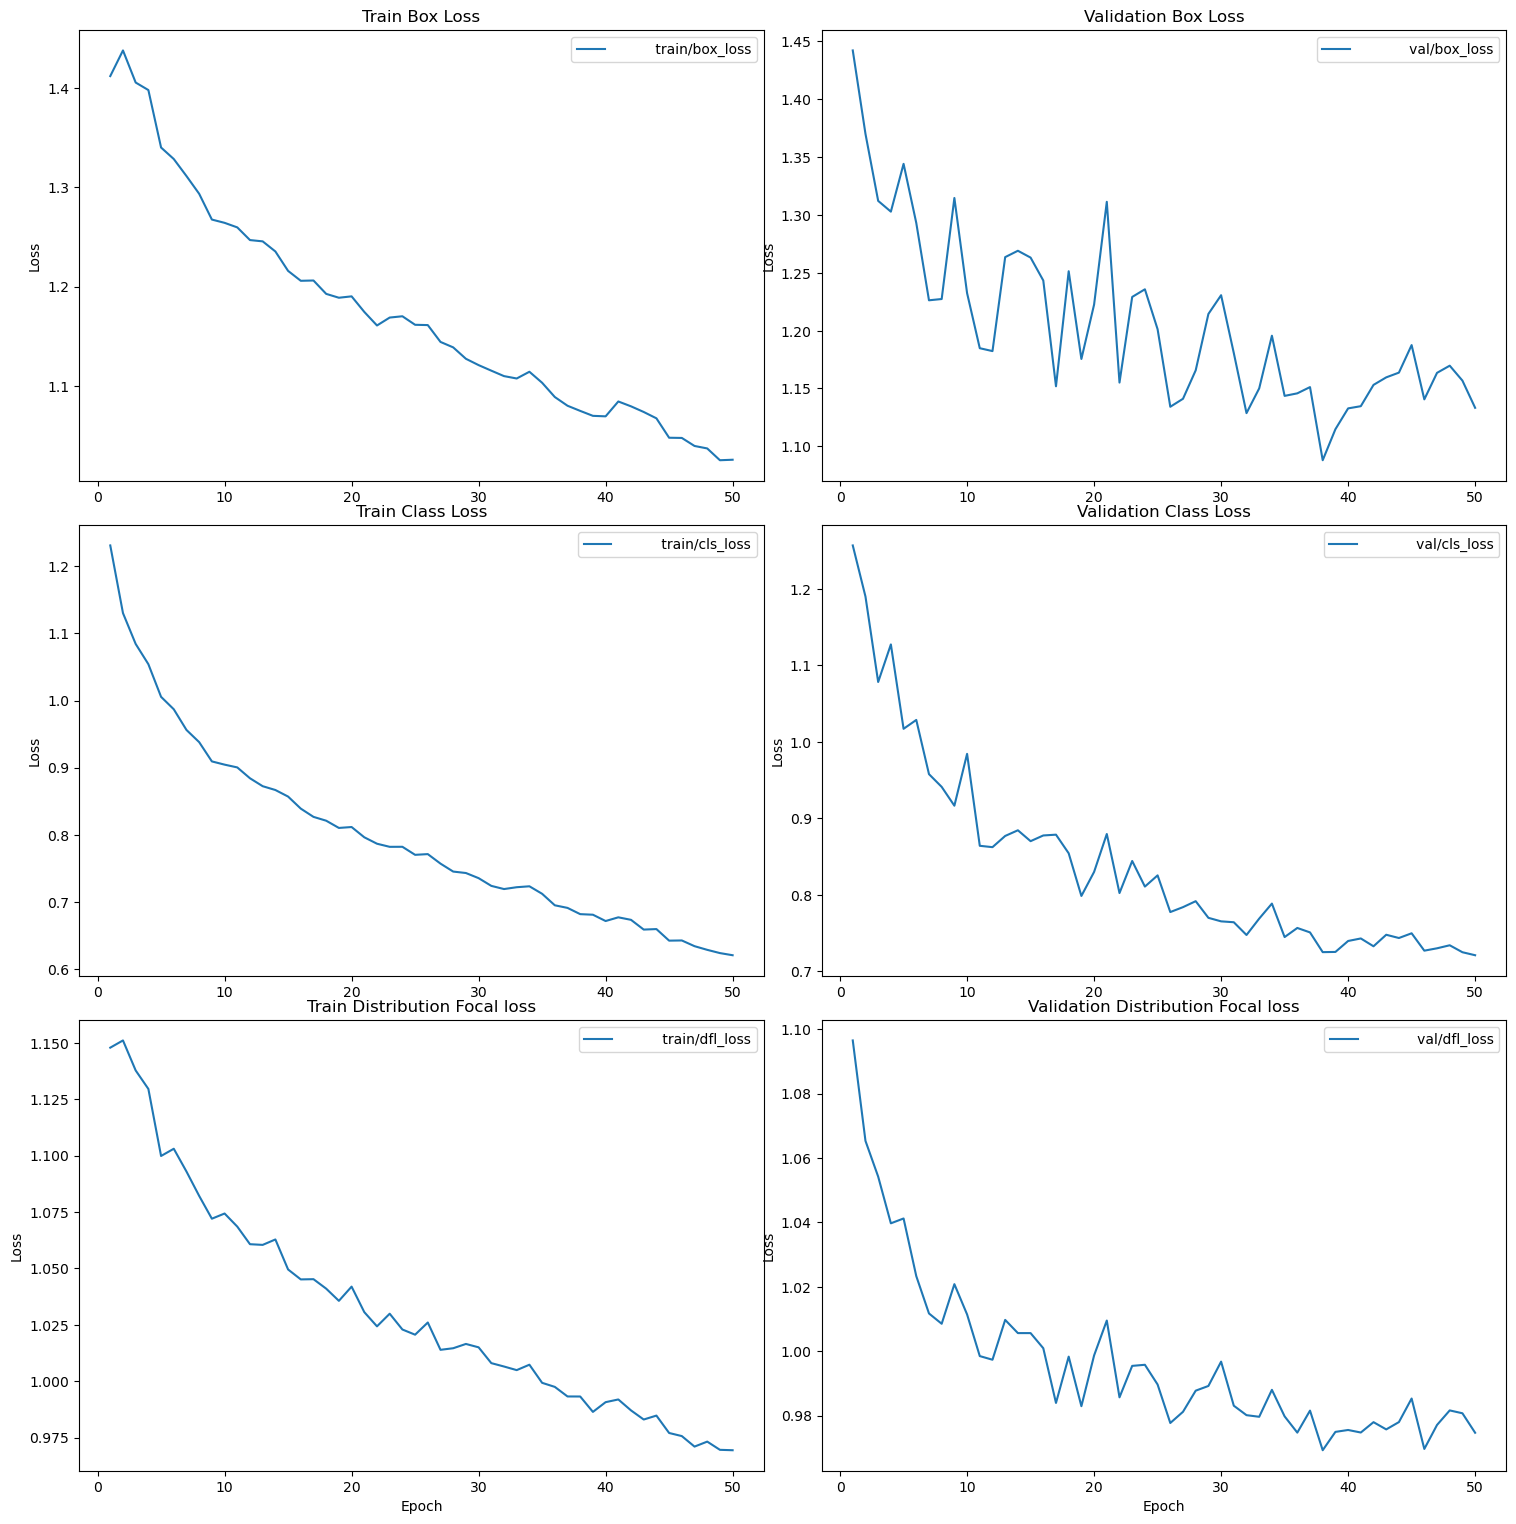

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

# train/box_loss
axes[0, 0].plot(df['                  epoch'], df['         train/box_loss'], label='         train/box_loss')
axes[0, 0].set_title('Train Box Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# val/box_loss
axes[0, 1].plot(df['                  epoch'], df['           val/box_loss'], label='           val/box_loss')
axes[0, 1].set_title('Validation Box Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# train/cls_loss
axes[1, 0].plot(df['                  epoch'], df['         train/cls_loss'], label='         train/cls_loss')
axes[1, 0].set_title('Train Class Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# val/cls_loss
axes[1, 1].plot(df['                  epoch'], df['           val/cls_loss'], label='           val/cls_loss')
axes[1, 1].set_title('Validation Class Loss')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# train/dfl_loss
axes[2, 0].plot(df['                  epoch'], df['         train/dfl_loss'], label='         train/dfl_loss')
axes[2, 0].set_title('Train Distribution Focal loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

# val/dfl_loss
axes[2, 1].plot(df['                  epoch'], df['           val/dfl_loss'], label='           val/dfl_loss')
axes[2, 1].set_title('Validation Distribution Focal loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

plt.show()

**Training metrics**

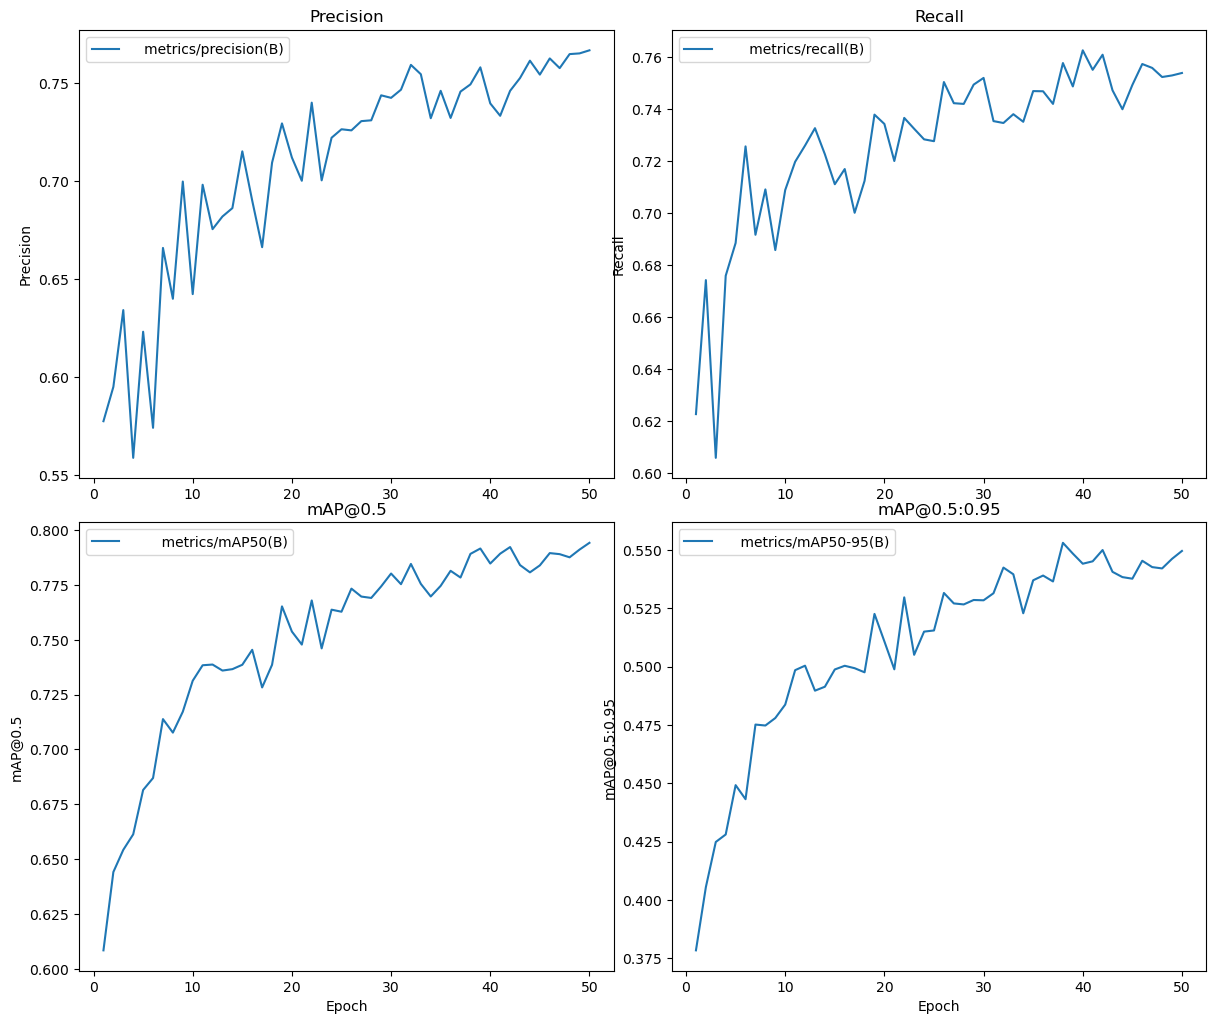

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

# metrics/precision(B)
axes[0, 0].plot(df['                  epoch'], df['   metrics/precision(B)'], label='   metrics/precision(B)')
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].legend()

# metrics/recall(B)
axes[0, 1].plot(df['                  epoch'], df['      metrics/recall(B)'], label='      metrics/recall(B)')
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

# Plot for metrics/mAP50(B)
axes[1, 0].plot(df['                  epoch'], df['       metrics/mAP50(B)'], label='       metrics/mAP50(B)')
axes[1, 0].set_title('mAP@0.5')
axes[1, 0].set_ylabel('mAP@0.5')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# metrics/mAP50-95(B)
axes[1, 1].plot(df['                  epoch'], df['    metrics/mAP50-95(B)'], label='    metrics/mAP50-95(B)')
axes[1, 1].set_title('mAP@0.5:0.95')
axes[1, 1].set_ylabel('mAP@0.5:0.95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.show()

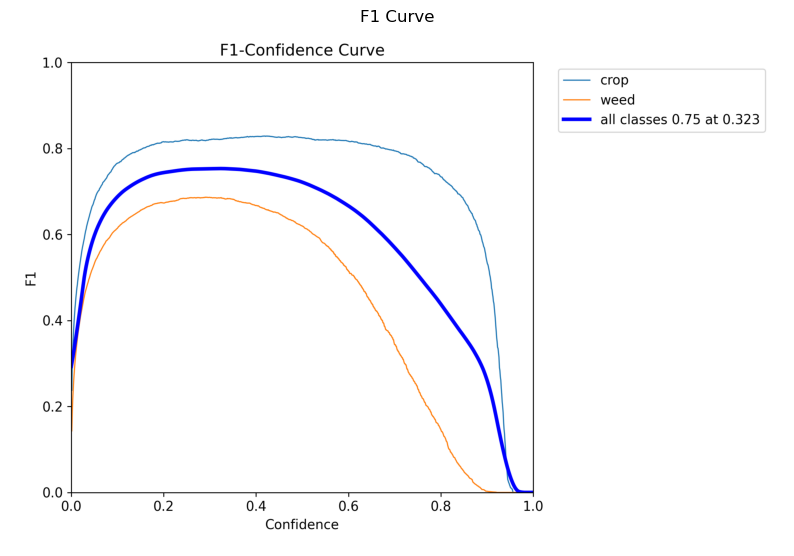

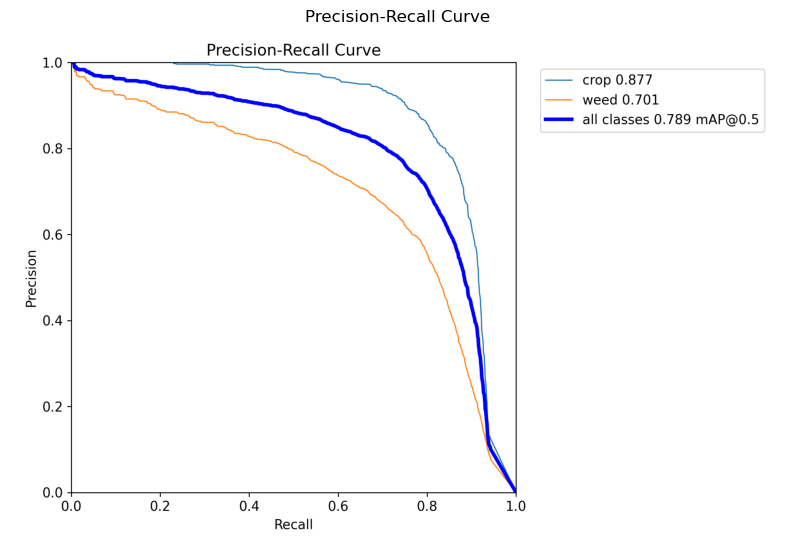

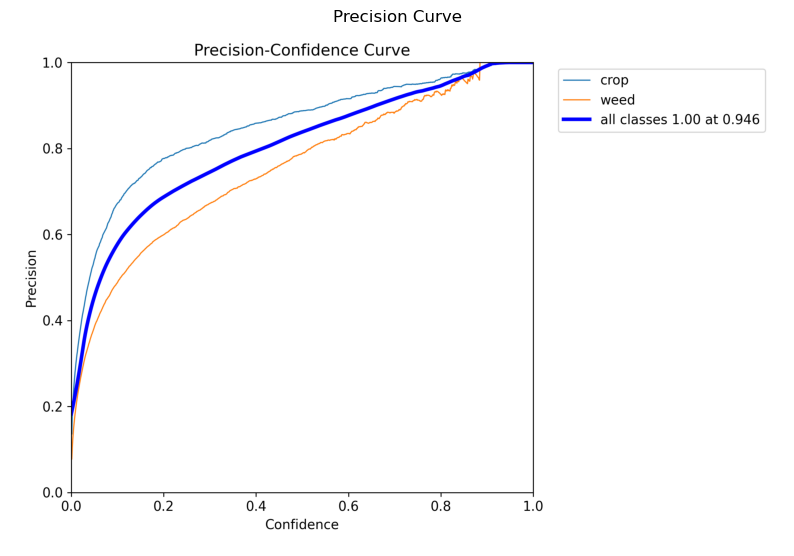

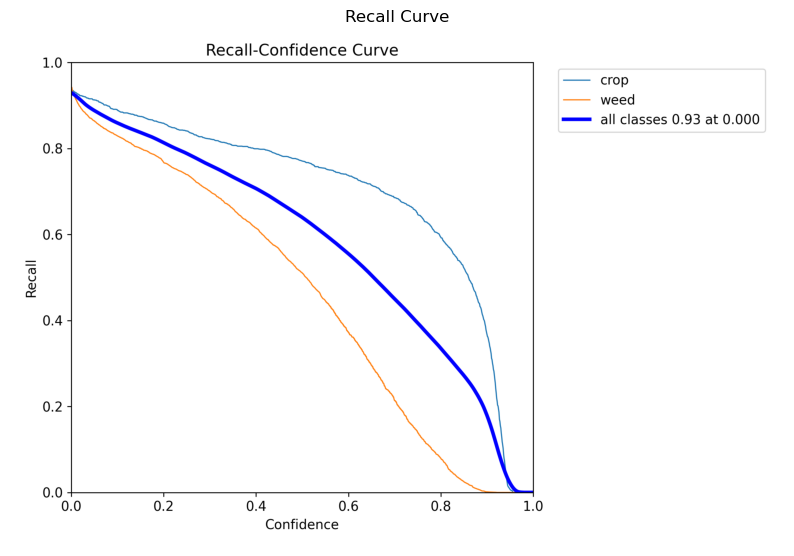

In [ ]:
# F1_curve.png
f1_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/F1_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(f1_curve)
plt.title("F1 Curve")
plt.axis("off")
plt.show()

# PR_curve.png
pr_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/PR_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(pr_curve)
plt.title("Precision-Recall Curve")
plt.axis("off")
plt.show()

# P_curve.png
p_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/P_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(p_curve)
plt.title("Precision Curve")
plt.axis("off")
plt.show()

# R_curve.png
r_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/R_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(r_curve)
plt.title("Recall Curve")
plt.axis("off")
plt.show()

**As seen from the precision-recall curve, crops have a high detection rate by the model, whereas weeds are not detected as well. More data with labeled weeds is needed.**

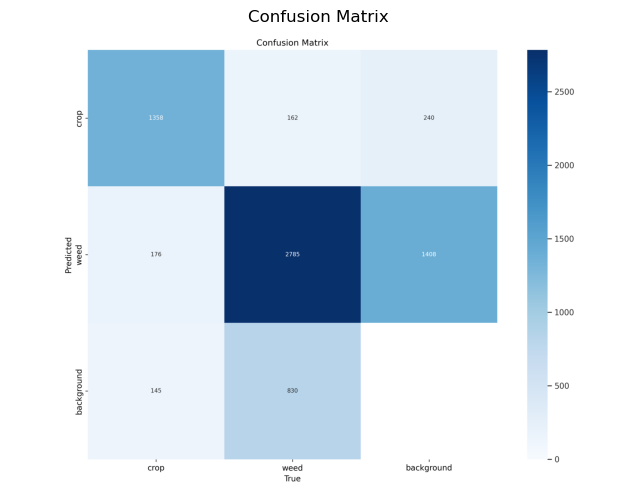

In [ ]:
# confusion matrix
confusion_matrix = Image.open("/kaggle/working/TG_YOLOv8x/Didi/confusion_matrix.png")
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.axis("off")
plt.show()

**The majority of errors made by our model were related to misclassifying objects as "background" when they were actually weeds - there were 903 such errors. Conversely, there were 955 errors where the model classified weeds as "background".**

**In other cases, the number of errors was minimal, around 100-200.**

# Evaluation

**Let's see how the model performs detection on the test set.**


image 1/1 /kaggle/working/test/images/bbro_bbro_14_05_2021_v_0_18.png: 384x640 4 crops, 81.6ms
Speed: 3.2ms preprocess, 81.6ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


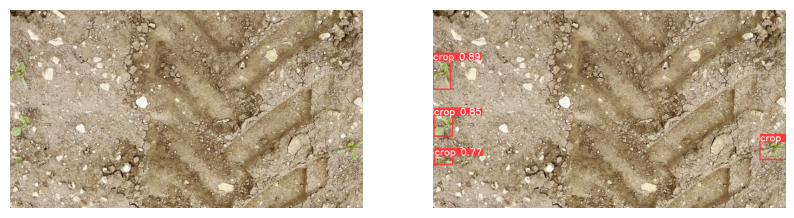

In [ ]:
res = model('/kaggle/working/test/images/bbro_bbro_14_05_2021_v_0_18.png')
detect_img = res[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Displaying the first image
axes[0].imshow(plt.imread('/kaggle/working/test/images/bbro_bbro_14_05_2021_v_0_18.png'))
axes[0].axis('off')

# Displaying model results
axes[1].imshow(detect_img)
axes[1].axis('off')

plt.show();

**We will save the weights of the model during training.**

In [ ]:
model = YOLO('TG_YOLOv8x/Didi/weights/best.pt ')

In [ ]:
metrics = model.val(split='test', conf=0.25, device=device) # `conf` - This is the confidence threshold for object detection.

Ultralytics YOLOv8.1.12 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/working/test/labels... 999 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:12<00:00, 77.20it/s]


val: New cache created: /kaggle/working/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


                   all       1001       8605      0.755       0.73      0.777      0.586
                  crop       1001       3354      0.837      0.806      0.873      0.741
                  weed       1001       5251      0.674      0.654       0.68      0.431
Speed: 0.6ms preprocess, 15.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


In [ ]:
metrics

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9cd67d72b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

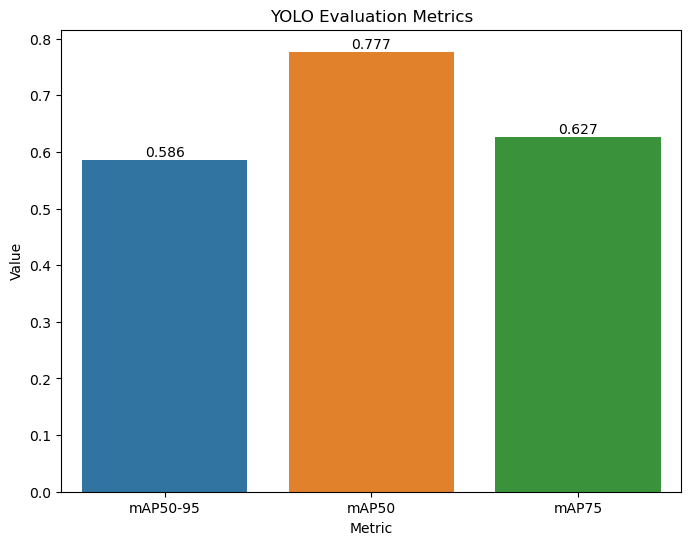

In [ ]:
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])


ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')


fig = plt.gcf()
fig.set_size_inches(8, 6)

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.show()

**Thus, the model demonstrates higher precision in object detection at lower confidence thresholds, while its precision decreases at higher thresholds. This may be because at higher confidence thresholds, the model becomes more conservative and misses some objects to reduce the likelihood of false positives.**

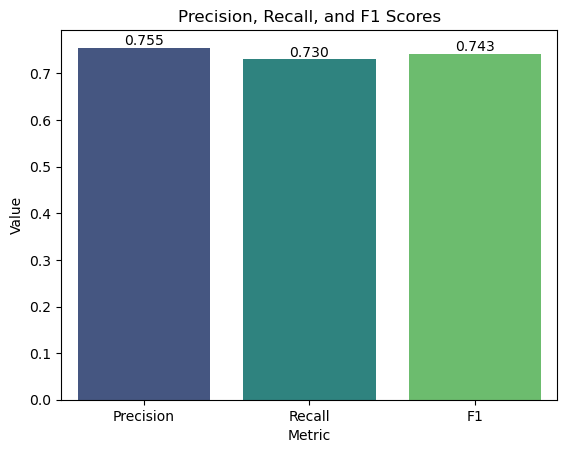

In [ ]:
# Extracting Precision, Recall, and F1 values
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
f1 = (2 * precision * recall) / (precision + recall)  # Вычисление F1


metrics = ['Precision', 'Recall', 'F1']
values = [precision, recall, f1]

# Creating a plot using sns.barplot
ax = sns.barplot(x=metrics, y=values, palette='viridis')

ax.set_title('Precision, Recall, and F1 Scores')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

As evident from the metrics, the model's precision is quite good; it effectively recognizes both classes and detects them with approximately equal performance.

Let's take a look at 10 random images.

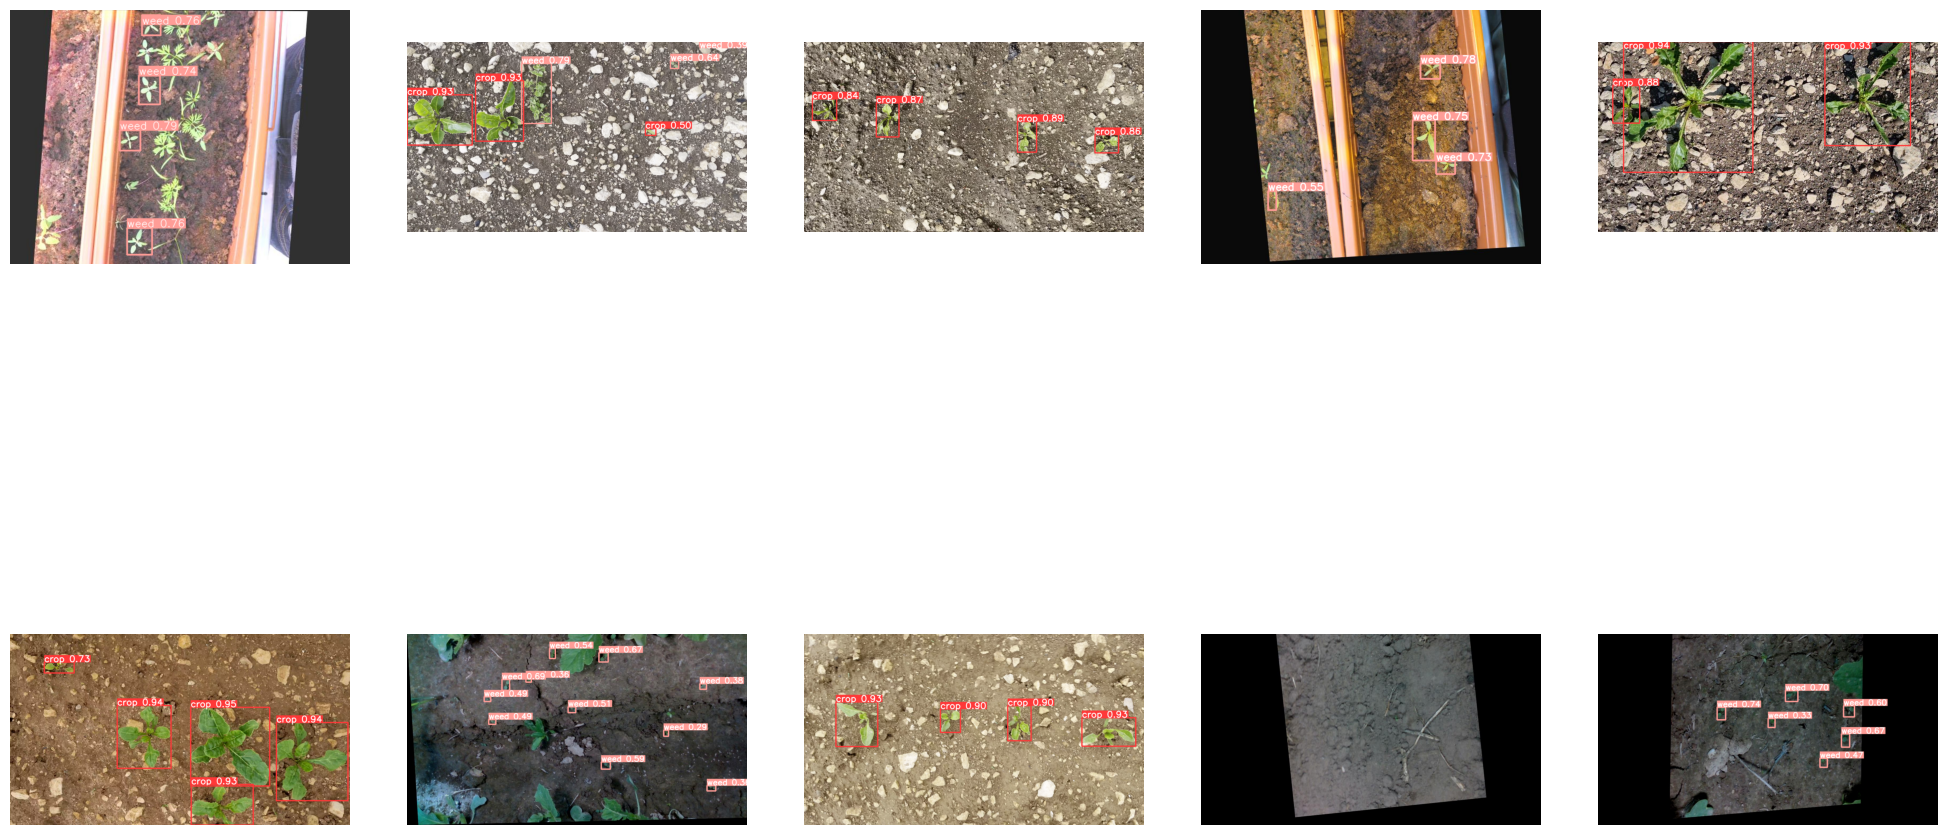

In [ ]:
# Getting random images
image_paths = random.sample(os.listdir(images_folder), 10)

# Creating a figure with subplots and larger photo size
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
fig.tight_layout()

# Iterating over each subplot
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(images_folder, image_paths[i])
    image = Image.open(image_path)
    res = model(image, verbose=False)
    detect_img = res[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    ax.imshow(detect_img)
    ax.axis('off')

plt.show()

**Conclusion**

In this notebook, we trained the YOLOv8x model on combined data, studied the metrics and losses during training, and analyzed the model's output on several images along with the detection quality on the test data.

To achieve higher model performance and successful application in business processes, it is recommended to conduct more thorough research. Here are some steps that can be taken:

1. **Gather more data:** A larger volume of diverse data will help the model generalize better and recognize objects more accurately. This can involve collecting new data or finding available datasets to supplement the current training set.

2. **Fine-tune hyperparameters:** Tuning the model's hyperparameters can significantly impact its performance. Experimenting with different values of hyperparameters such as anchor sizes, confidence thresholds, and others can lead to better results.

3. **Conduct additional experiments:** Experimenting with different model architectures, variations of YOLOv8, or other object detection models can potentially yield better results.

Overall, more precise research (especially the need for more annotated data with labels and bounding boxes for weeds), experimentation, and efforts to improve the model will lead to higher performance and increased applicability in real-world business scenarios. Of course, everything comes down to resources, both computational and financial.